# Feature selection (Colab)

!pip install pandas==1.0.1
!pip install numpy==1.18.1
!pip install pyarrow==0.15.0
!pip install s3fs==0.4.0
!pip install matplotlib==3.1.1
!pip install seaborn==0.10.0
!pip install keras==2.3.1
!pip install scikit-learn==0.22.1

## 0. Set-up

In [1]:
import os
import getpass

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [6]:
AWS_ACCESS_KEY_ID = getpass.getpass()
AWS_SECRET_KEY = getpass.getpass()

 ····················
 ········································


In [7]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## 1. Preprocessing

### Load FFS data

In [8]:
ffs_all_data_1719 = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_all_features_1718_to_1819.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data_1719.shape)
ffs_all_data_1719.head()

(20449, 308)


,Name,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,full_name,season,gw,Attempts From Set Plays Conceded,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Conceded,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Conceded (Centre Zone),Chances Conceded (Left Zone),Chances Conceded (Right Zone),Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Percentage Centre Zone),Chances Created (Percentage Left Zone),Chances Created (Percentage Right Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Percentage Left Zone),Crosses - Opponents Half (Percentage Right Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses Conceded (Left Zone),Crosses Conceded (Right Zone),Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Games Played,Goal Attempts,Goal Attempts Conceded,Goal Attempts In Box Conceded,Goal Attempts Outside Box Conceded,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goal Attempts Conceded,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Big Chance,Minutes Per Big Chance Conceded,Minutes Per Block,Minutes Per Chance,Minutes Per Chance Conceded,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xG Conceded,Minutes Per xG On Target Conceded,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Open Play Goal Attempts,Open Play Goal Attempts Conceded,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - 

In [9]:
ffs_all_data_1719.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

In [10]:
columns_with_inf = []
for col in ffs_all_data_1719.columns:
    if np.inf in ffs_all_data_1719[col].values:
        print(col)
        print(ffs_all_data_1719[ffs_all_data_1719['Minutes Per xA'] == np.inf].shape[0] / ffs_all_data_1719.shape[0])
        columns_with_inf.append(col)
        print('\n')

Minutes Per xA
0.30275319086507896


Minutes Per xG
0.30275319086507896


Minutes Per xGI
0.30275319086507896


Minutes Per xGP
0.30275319086507896


Sky Minutes Per Bonus
0.30275319086507896




Looks like `inf` caused by divide by zero error. For now let's impute with 0 but if these features are shown to be predictive then may need to revisit this. Could use a very large number instead.

In [11]:
for col in columns_with_inf:
    ffs_all_data_1719[col].replace({np.inf: 0}, inplace=True)

nan

In [12]:
ffs_all_data_1719.replace({'nan': np.nan}, inplace=True)

### Drop features with all nulls

In [13]:
ffs_all_data_1719.dropna(axis=1, how='all', inplace=True)

### Add 0 minute events back into data

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

In [14]:
ffs_all_data_1719['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

In [15]:
ffs_data_names = ffs_all_data_1719[['name', 'Team', 'position']].drop_duplicates()
ffs_data_names['key'] = 1
ffs_data_names.shape

(721, 4)

In [16]:
seasons_df = pd.DataFrame({'season': ['2017-2018', '2018-2019']})
seasons_df['key'] = 1
seasons_df

,season,key
0,2017-2018,1
1,2018-2019,1


In [17]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [18]:
all_season_gw_df = seasons_df.merge(gw_df, on='key')

In [19]:
all_season_gw_df.head()

,season,key,gw
0,2017-2018,1,1
1,2017-2018,1,2
2,2017-2018,1,3
3,2017-2018,1,4
4,2017-2018,1,5


In [20]:
all_player_season_gw_df = all_season_gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(54796, 5)

In [21]:
all_player_season_gw_df.head()

,season,gw,name,Team,position
0,2017-2018,1,gabriel_fernando de jesus,MCI,FWD
1,2017-2018,1,danny_welbeck,ARS,FWD
2,2017-2018,1,sam_vokes,BUR,FWD
3,2017-2018,1,jamie_vardy,LEI,FWD
4,2017-2018,1,diafra_sakho,WHU,FWD


In [22]:
ffs_data = all_player_season_gw_df.merge(ffs_all_data_1719, on=['name', 'Team', 'position', 'gw', 'season'], how='left')
print(ffs_data.shape)
ffs_data.head()

(54796, 278)


,season,gw,name,Team,position,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [23]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,season,gw,name,Team,position,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [24]:
ffs_data.isnull().sum()

season                                   0
gw                                       0
name                                     0
Team                                     0
position                                 0
                                     ...  
xG Prevented                         34347
xG Set Play                          34347
xGI Delta (Goals + Assists - xGI)    34347
xGI Expected Goal Involvement        34347
total_points                         34347
Length: 278, dtype: int64

In [25]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

### Position dummies

In [26]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [27]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gameweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [28]:
fixture_and_odds_features = pd.read_parquet('data/processed/formatted_fixture_and_odds_features_2016_to_2019.parquet')
print(fixture_and_odds_features.shape)
fixture_and_odds_features.head()

(2193, 19)


,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


### Format FFS team names and seasons to match

In [29]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [30]:
ffs_data['season'].replace({'2017-2018': '2017-18', '2018-2019': '2018-19'}, inplace=True)

In [31]:
ffs_team_name_to_fpl = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton & Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City'
}

In [32]:
ffs_data['team_name'].replace(ffs_team_name_to_fpl, inplace=True)

In [33]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [34]:
ffs_data.shape

(54796, 281)

### Combine feature and odds features

In [35]:
fixture_and_odds_features.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


In [36]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [37]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
print(ffs_data.shape)

ffs_data = ffs_data.merge(
    fixture_and_odds_features, 
    on=['season', 'gw', 'team_name'], 
    how='inner'
)

print(ffs_data.shape)

ffs_data.head()

(54796, 281)
(46926, 297)


,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [38]:
ffs_data[
    (ffs_data['season'] == '2017-18') & (ffs_data['gw'] == 36) & (ffs_data['team_name'] == 'Arsenal')
].head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [39]:
ffs_data[
    (ffs_data['season'] == '2017-18') & (ffs_data['gw'] == 37) & (ffs_data['team_name'] == 'Arsenal')
].head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

### Drop certain features

In [40]:
FEATURES_TO_DROP = [
    'Overall Points',
    'Starts',
    'Appearances',
    'BPS Baseline',
    'BPS CBI',
    'BPS Clean Sheets',
    'BPS Goals',
    'BPS Pass Completion',
    'BPS Recoveries',
    'BPS Time Played',
    'BPS Yellow Cards',
    'Minutes Per Baseline BPS',
    'Exact Time Played',
    'Ownership',
    'Bonus Points'
]

In [41]:
ffs_data.drop(columns=FEATURES_TO_DROP, inplace=True)

## 2. Create target and train/dev/test splits

### Create target

In [42]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [43]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Own Goals,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties Missed,Premier League Straight Red Cards,Premier League Total Red Cards,Premier League Yellow Cards,Recoveries,Saves,Saves (Shots Inside Box),Saves (Shots Outside Box),Saves - Caught,Saves - Claims,Saves - Di

In [44]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

### Train/dev/test split

In [45]:
training_df, test_df = custom_train_test_split(ffs_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)
training_df.head()

Proportion in test set: 0.09361012001297438
Test set size: (4329, 284)
Training set size: (41916, 284)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Own Goals,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties Missed,Premier League Straight Red Cards,Premier League Total Red Cards,Premier League Yellow Cards,Recoveries,Saves,Saves (Shots Inside Box),Saves (Shots Outside Box),Saves - Caught,Saves - Claims,Saves - Di

In [46]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10955243820975284
Test set size: (4592, 284)
Training set size: (37324, 284)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
print(f"Proportion training: {training_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/ffs_data.shape[0]}")

Proportion training: 0.8070926586658017
Proportion dev: 0.09929722132122391
Proportion test: 0.09361012001297438


### Filter out ineligible players

In [48]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [49]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

## 3. Fit a univariate LSTM for each feature and record bootstrapped dev set error 

In [50]:
COLUMNS_TO_SCALE = list(training_df.select_dtypes('number').columns.drop('total_points_plus1_gw'))
len(COLUMNS_TO_SCALE)

279

### Normalise features

In [51]:
mms = MinMaxScaler()

mms.fit(training_df[COLUMNS_TO_SCALE])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
training_df[COLUMNS_TO_SCALE] = mms.transform(training_df[COLUMNS_TO_SCALE])

In [53]:
dev_df[COLUMNS_TO_SCALE] = mms.transform(dev_df[COLUMNS_TO_SCALE])
test_df[COLUMNS_TO_SCALE] = mms.transform(test_df[COLUMNS_TO_SCALE])

### Prepare data for LSTM

In [54]:
def prepare_data_for_lstm(df, feature_list):
    df = df.copy()

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[feature_list + ['total_points_plus1_gw']]

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [55]:
X_train, y_train = prepare_data_for_lstm(training_df, feature_list=COLUMNS_TO_SCALE)
X_dev, y_dev = prepare_data_for_lstm(dev_df, feature_list=COLUMNS_TO_SCALE)
X_test, y_test = prepare_data_for_lstm(test_df, feature_list=COLUMNS_TO_SCALE)

(32052, 5, 279)
(32052, 5)
(3705, 5, 279)
(3705, 5)
(3455, 5, 279)
(3455, 5)


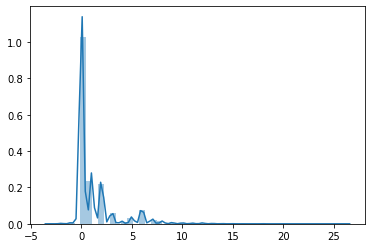

In [56]:
sns.distplot(y_train.flatten())

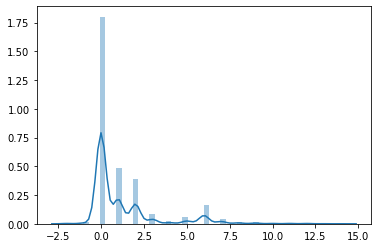

In [57]:
sns.distplot(y_dev.flatten())

True split after filtering:

In [58]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.8174028358665715
Proportion dev: 0.09448638171988166
Proportion test: 0.08811078241354688


We use a simple model with a single 100-node LSTM layer. 

In [59]:
def create_model(n_inputs):
    X_input = Input(shape=(N_STEPS_IN, n_inputs,))
    
    X = LSTM(100, return_sequences=False)(X_input)
    X = Dropout(rate=0.1)(X)
    
#     X = LSTM(150, return_sequences=False)(X)
#     X = Dropout(rate=0.1)(X)
    
#     X = Dense(100)(X)
#     X = BatchNormalization()(X)
#     X = Activation('relu')(X)
#     X = Dropout(rate=0.1)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.00005)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

# TODO: In Colab change epochs to 100 and trials to 100

In [73]:
univariate_lstm_mse = {}

for i, feature in enumerate(COLUMNS_TO_SCALE):
    print(feature, f'({i+1}/{len(COLUMNS_TO_SCALE)})')
    # Train model
    new_lstm_model = create_model(n_inputs=1)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

    new_lstm_model.fit(
        X_train[:, :, [i]], 
        y_train, 
        batch_size=256, 
        epochs=1, 
        validation_data=(
            X_dev[:, :, [i]], 
            y_dev
            ),
        verbose=0,
        callbacks=[es]
    )

    mse_list_new = []

    # Calculate bootstrap error
    for trial in range(1):
        idx = np.random.choice(X_dev[:, :, [i]].shape[0], size=X_dev[:, :, [i]].shape[0], replace=True)
        predictions = new_lstm_model.predict(X_dev[:, :, [i]][idx, :, :])

        mse = mean_squared_error(y_dev[idx], predictions)

        mse_list_new.append(mse)

    mse_mean = np.mean(mse_list_new)
    mse_std = np.std(mse_list_new)

    print(f'Mean MSE: {mse_mean}')
    print(f'Std MSE: {mse_std}')

    univariate_lstm_mse[feature] = {
        'mean': mse_mean,
        'std': mse_std
    }
    print('\n')

gw (1/279)
Mean MSE: 5.259683436643906
Std MSE: 0.0


Aerial Duels - Won - Percentage (2/279)
Mean MSE: 5.333978617605781
Std MSE: 0.0


Aerial Duels Lost (3/279)
Mean MSE: 5.455134429129769
Std MSE: 0.0


Aerial Duels Total (4/279)
Mean MSE: 5.349451322266996
Std MSE: 0.0


Aerial Duels Won (5/279)
Mean MSE: 5.375592543124644
Std MSE: 0.0


Assists (6/279)
Mean MSE: 5.594882366971476
Std MSE: 0.0


Attempts From Crossed Corners (7/279)
Mean MSE: 5.295995220054678
Std MSE: 0.0


Attempts From Direct Free-kick (8/279)
Mean MSE: 5.644374928351081
Std MSE: 0.0


Attempts From Indirect Free-kick (9/279)
Mean MSE: 5.375267792881365
Std MSE: 0.0


Attempts From Set Plays (10/279)
Mean MSE: 5.40934835042616
Std MSE: 0.0


Attempts from Throw-in (11/279)
Mean MSE: 5.727021680038243
Std MSE: 0.0


Bad Touches (12/279)
Mean MSE: 5.755466600701581
Std MSE: 0.0


Big Chances Created (13/279)
Mean MSE: 5.414311072244769
Std MSE: 0.0


Big Chances Missed (14/279)
Mean MSE: 5.669018909170424
Std MSE:

In [81]:
univariate_lstm_mse_df = pd.DataFrame(univariate_lstm_mse).T.reset_index().rename(columns={'index': 'feature'})
univariate_lstm_mse_df.sort_values('mean', ascending=False, inplace=True)
univariate_lstm_mse_df.head()

,feature,mean,std
31,Clearances - Unsuccessful,5.918478,0.0
14,Big Chances Missed Ball,5.902927,0.0
205,Sky Bonus Saves Tier 2,5.874751,0.0
139,Passes - Forward - Successful,5.854458,0.0
204,Sky Bonus Saves Tier 1,5.844852,0.0


In [83]:
univariate_mse_cutoff = np.quantile(univariate_lstm_mse_df['mean'], 0.2)
univariate_mse_cutoff

5.441959256909045

In [86]:
FEATURES_DROPPED_AFTER_UNIVARIATE = list(univariate_lstm_mse_df[univariate_lstm_mse_df['mean'] <= univariate_mse_cutoff]['feature'])
print(len(FEATURES_DROPPED_AFTER_UNIVARIATE))
FEATURES_DROPPED_AFTER_UNIVARIATE

56


['Chances Created (Right Zone)',
 'Passes - Opponents Half - Left - Successful',
 'Saves (Shots Inside Box)',
 'Minutes Per Goal Attempt In Box',
 'Time Played',
 'Minutes Per Shot On Target',
 'Goals',
 'Crosses - Open Play - Unsuccessful',
 'xG On Target Freekick',
 'Shots - Six Yard Box',
 'Goals From Open Play',
 'Big Chances Created',
 'Chances Created (Centre Zone)',
 'Attempts From Set Plays',
 'Touches - Opponents Half',
 'Passing - Through Balls',
 'ICT Index',
 'Sky Bonus Tackles Tier 1',
 'Tackles Won - Possession',
 'Second Yellow Cards',
 'Pass Completion - Final Third',
 'Short Corners',
 'Passes - Opponents Half (Left)',
 'xG Delta (Goals - xG)',
 'position_MID',
 'Shots - Long - On Target',
 'next_gameweek_number_of_promoted_side_opponent',
 'Key Passes',
 'position_DEF',
 'Total Assists',
 'Aerial Duels Won',
 'Attempts From Indirect Free-kick',
 'Minutes Per Chances Created',
 'Headed Goals',
 'Headed Attempts From Set Plays',
 'Saves - Diving',
 'top_6_last_season',


## 4. Fit LSTM on remaining features and remove bottom quantile based on PFI

In [63]:
ROUND_1_FEATURES = list(
    set(COLUMNS_TO_SCALE) - set(FEATURES_DROPPED_AFTER_UNIVARIATE)
)

In [65]:
X_train, y_train = prepare_data_for_lstm(training_df, feature_list=ROUND_1_FEATURES)
X_dev, y_dev = prepare_data_for_lstm(dev_df, feature_list=ROUND_1_FEATURES)
X_test, y_test = prepare_data_for_lstm(test_df, feature_list=ROUND_1_FEATURES)

(32052, 5, 223)
(32052, 5)
(3705, 5, 223)
(3705, 5)
(3455, 5, 223)
(3455, 5)


In [66]:
lstm_model = create_model(223)

In [67]:
lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 223)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               129600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 130,105
Trainable params: 130,105
Non-trainable params: 0
_________________________________________________________________


In [68]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    epochs=100, 
    validation_data=(
        X_dev, 
        y_dev
    ),
    callbacks=[es]
)

Train on 32052 samples, validate on 3705 samples
Epoch 1/100
32052/32052 [==============================] - 3s 79us/step - loss: 5.2424 - val_loss: 4.3763
Epoch 2/100
32052/32052 [==============================] - 2s 64us/step - loss: 3.9272 - val_loss: 3.6110
Epoch 3/100
32052/32052 [==============================] - 2s 67us/step - loss: 3.5913 - val_loss: 3.5735
Epoch 4/100
32052/32052 [==============================] - 2s 67us/step - loss: 3.5363 - val_loss: 3.5552
Epoch 5/100
32052/32052 [==============================] - 2s 69us/step - loss: 3.5016 - val_loss: 3.5430
Epoch 6/100
32052/32052 [==============================] - 2s 66us/step - loss: 3.4744 - val_loss: 3.5367
Epoch 7/100
32052/32052 [==============================] - 2s 65us/step - loss: 3.4564 - val_loss: 3.5305
Epoch 8/100
32052/32052 [==============================] - 2s 65us/step - loss: 3.4422 - val_loss: 3.5280
Epoch 9/100
32052/32052 [==============================] - 2s 60us/step - loss: 3.4337 - val_loss: 3.52

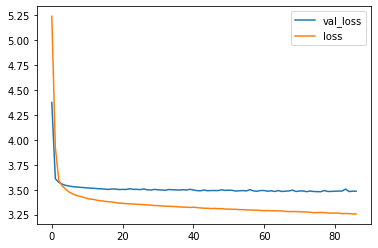

In [69]:
pd.DataFrame(lstm_model.history.history).plot()

In [70]:
dev_error = mean_squared_error(y_dev, lstm_model.predict(X_dev))
dev_error

3.4848298317471427

### Permutation feature importance

In [71]:
model_error = mean_squared_error(y_train, lstm_model.predict(X_train))

In [73]:
def calculate_pfi(X, fitted_model, model_error, num_trials, feature_list):

    pfi_dict = {}

    for i, feature in enumerate(feature_list):
        print(feature, f'({i+1}/{len(feature_list)})')

        X_train_copy = np.copy(X)

        pfi_trials = []
        for trial in range(num_trials):

            feature_array = X_train_copy[:, :, i]
            num_rows, num_cols = feature_array.shape

            shuffled_flattened = feature_array.flatten()

            np.random.shuffle(shuffled_flattened)  # shuffles in-place

            shuffled_array = shuffled_flattened.reshape(num_rows, num_cols)

            X_train_copy[:, :, i] = shuffled_array

            predictions_shuffled = fitted_model.predict(X_train_copy)

            model_error_perm = mean_squared_error(y_train, predictions_shuffled)

            pfi = model_error_perm / model_error

            pfi_trials.append(pfi)

        mean_pfi = np.mean(pfi_trials)
        std_pfi = np.std(pfi_trials)

        pfi_dict[feature] = {'mean': mean_pfi, 'std': std_pfi}
    
    return pfi_dict

In [75]:
pfi_dict = calculate_pfi(X_train, model_error=model_error, fitted_model=lstm_model, num_trials=1, feature_list=ROUND_1_FEATURES)

Clearances - Unsuccessful (1/223)
Minutes Per Chance (2/223)
Second Yellow Cards (3/223)
Sky Bonus Saves Tier 1 (4/223)
Aerial Duels - Won - Percentage (5/223)
Passing - Through Balls (6/223)
draw_odds (7/223)
Goals Conceded (8/223)
Minutes Per Shot On Target (9/223)
Lay-offs (10/223)
Touches - Opponents Half - Right (11/223)
Goal Conversion (12/223)
Goals From Open Play (13/223)
Net Tackles (14/223)
Attempts From Indirect Free-kick (15/223)
Throws - Unsuccessful (16/223)
Passes - Opponents Half - Left - Unsuccessful (17/223)
xG On Target Non Penalty (18/223)
Corner Conversion (19/223)
Corners (20/223)
Passes - Long - Successful (21/223)
Headed Goal Attempts - Off Target (22/223)
Touches - Own Half (23/223)
Assists (24/223)
xG Set Play (25/223)
Key Contributions (26/223)
Passes - Own Half (27/223)
Saves - Diving (28/223)
Duels Lost (29/223)
Aerial Duels Lost (30/223)
Shots Off Target (31/223)
xG Prevented (32/223)
xG On Target (33/223)
Goals From Penalties (34/223)
Saves - Parried (35/

In [76]:
pfi_df = pd.DataFrame(pfi_dict).T
pfi_df.sort_values('mean', ascending=False, inplace=True)
pfi_df

,mean,std
Pass Completion,1.022425,0.0
Minutes Per Touch,1.008269,0.0
top_6_last_season,1.006994,0.0
position_DEF,1.004299,0.0
next_gameweek_win_odds,1.003702,0.0
...,...,...
Passes Received - Opponents Half (Left),1.000013,0.0
Attempts From Direct Free-kick,1.000005,0.0
Clearances - Unsuccessful,1.000000,0.0
Saves - Claims,0.999996,0.0


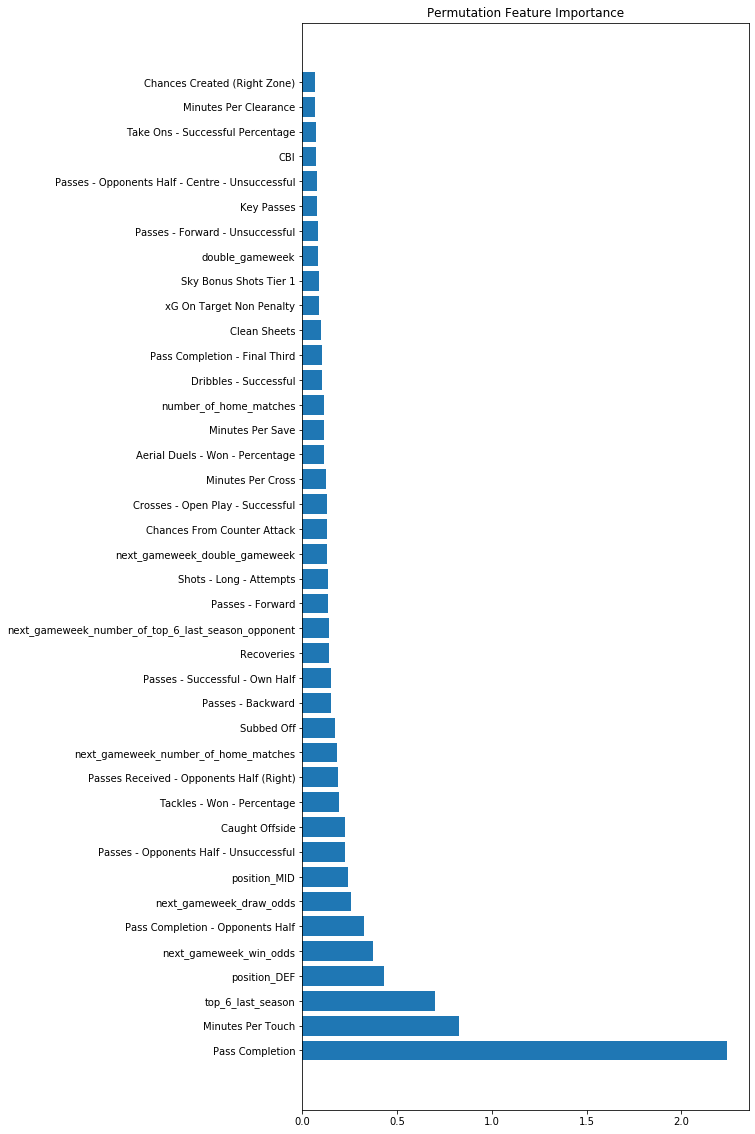

In [77]:
plt.figure(figsize=(8, 20))
plt.barh(
    pfi_df.head(40).index, 
    (pfi_df.head(40)['mean'] - 1) * 100
)
plt.title('Permutation Feature Importance')
plt.show()

In [80]:
pfi_cutoff = np.quantile(pfi_df['mean'], 0.1)
pfi_cutoff

1.0000501896119913

In [81]:
PFI_FEATURES_TO_DROP = list(pfi_df[pfi_df['mean'] < pfi_cutoff].index)

In [82]:
FEATURE_SELECTION_DATA = {}

FEATURE_SELECTION_DATA['ROUND_1'] = {
    'features': ROUND_1_FEATURES,
    'model': lstm_model,
    'dev_error': dev_error,
    'features_to_drop': PFI_FEATURES_TO_DROP
}

In [84]:
NUM_ROUNDS = 5

In [87]:
for round in range(2, NUM_ROUNDS + 1):
    print(f'Starting round {round}')

    features_for_round = list(
        set(FEATURE_SELECTION_DATA[f'ROUND_{round-1}']['features']) - set(FEATURE_SELECTION_DATA[f'ROUND_{round-1}']['features_to_drop'])
    )

    print(f'Number of features in round: {len(features_for_round)}')

    X_train, y_train = prepare_data_for_lstm(training_df, feature_list=features_for_round)
    X_dev, y_dev = prepare_data_for_lstm(dev_df, feature_list=features_for_round)
    X_test, y_test = prepare_data_for_lstm(test_df, feature_list=features_for_round)

    n_inputs = X_train.shape[2]
    print(n_inputs)

    lstm_model = create_model(n_inputs)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

    lstm_model.fit(
        X_train, 
        y_train, 
        batch_size=256, 
        epochs=100, 
        validation_data=(
            X_dev, 
            y_dev
        ),
        callbacks=[es]
    )

    dev_error = mean_squared_error(y_dev, lstm_model.predict(X_dev))
    print(f"Dev error: {dev_error}")

    # PFI
    model_error = mean_squared_error(y_train, lstm_model.predict(X_train))

    pfi_dict = calculate_pfi(
        X_train, 
        model_error=model_error, 
        fitted_model=lstm_model, 
        num_trials=1, 
        feature_list=features_for_round
    )

    pfi_df = pd.DataFrame(pfi_dict).T
    pfi_df.sort_values('mean', ascending=False, inplace=True)

    print(pfi_df.head(10))

    pfi_cutoff = np.quantile(pfi_df['mean'], 0.1)
    PFI_FEATURES_TO_DROP = list(pfi_df[pfi_df['mean'] < pfi_cutoff].index)

    FEATURE_SELECTION_DATA[f'ROUND_{round}'] = {
        'features': features_for_round,
        'model': lstm_model,
        'dev_error': dev_error,
        'features_to_drop': PFI_FEATURES_TO_DROP
    }
    print(FEATURE_SELECTION_DATA[f'ROUND_{round}'])
    print(f'Finished round {round}')
    print('\n')

Starting round 2
Number of features in round: 200
(32052, 5, 200)
(32052, 5)
(3705, 5, 200)
(3705, 5)
(3455, 5, 200)
(3455, 5)
200
Train on 32052 samples, validate on 3705 samples
Epoch 1/100
32052/32052 [==============================] - 3s 81us/step - loss: 5.4592 - val_loss: 4.5919
Epoch 2/100
32052/32052 [==============================] - 2s 70us/step - loss: 4.0415 - val_loss: 3.6253
Epoch 3/100
32052/32052 [==============================] - 2s 62us/step - loss: 3.6128 - val_loss: 3.6000
Epoch 4/100
32052/32052 [==============================] - 2s 63us/step - loss: 3.5669 - val_loss: 3.5771
Epoch 5/100
32052/32052 [==============================] - 2s 63us/step - loss: 3.5336 - val_loss: 3.5631
Epoch 6/100
32052/32052 [==============================] - 2s 68us/step - loss: 3.5104 - val_loss: 3.5504
Epoch 7/100
32052/32052 [==============================] - 2s 68us/step - loss: 3.4849 - val_loss: 3.5439
Epoch 8/100
32052/32052 [==============================] - 2s 64us/step - loss

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/abc.py", line 139, in __instancecheck__
    return _abc_instancecheck(cls, instance)
KeyboardInterrupt


(32052, 5, 162)
(32052, 5)
(3705, 5, 162)
(3705, 5)
(3455, 5, 162)
(3455, 5)
162
Train on 32052 samples, validate on 3705 samples
Epoch 1/100
32052/32052 [==============================] - 2s 71us/step - loss: 5.3263 - val_loss: 4.5202
Epoch 2/100
32052/32052 [==============================] - 2s 57us/step - loss: 4.0557 - val_loss: 3.6626
Epoch 3/100
32052/32052 [==============================] - 2s 53us/step - loss: 3.6168 - val_loss: 3.5955
Epoch 4/100
32052/32052 [==============================] - 2s 54us/step - loss: 3.5595 - val_loss: 3.5757
Epoch 5/100
32052/32052 [==============================] - 2s 50us/step - loss: 3.5291 - val_loss: 3.5608
Epoch 6/100
32052/32052 [==============================] - 2s 50us/step - loss: 3.4995 - val_loss: 3.5488
Epoch 7/100
32052/32052 [==============================] - 2s 50us/step - loss: 3.4763 - val_loss: 3.5402
Epoch 8/100
32052/32052 [==============================] - 2s 51us/step - loss: 3.4551 - val_loss: 3.5339
Epoch 9/100
32052/3205

KeyboardInterrupt: 